In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from koopmanlib.param_solver import KoopmanParametricDLSolver, KoopmanLinearDLSolver, KoopmanBilinearDLSolver
from koopmanlib.dictionary import PsiNN
from tensorflow.keras.optimizers import Adam
import json
import sys
import numpy as np
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


2024-02-28 11:16:24.377366: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
config_file = 'config_vdpm.json'

In [4]:


# config_file = sys.argv[1]
with open(config_file, 'r') as f:
    config = json.load(f)

data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

n_psi_train = config['nn_settings']['n_psi_train']
mu_list = config['data_settings']['mu']


target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size_list = config['nn_settings']['K_layer_size']

linear_epochs = config['nn_settings']['linear_epochs']
bilinear_epochs = config['nn_settings']['bilinear_epochs']
pknn_epochs = config['nn_settings']['pknn_epochs']


In [5]:

# class CustomLoss(tf.keras.losses.Loss):
#     def __init__(self, time_step, **kwargs):
#         super().__init__(**kwargs)
#         self.time_step = time_step

#     def call(self, y_true, y_pred):  
   
#         # # mse loss on psi
#         # mse = tf.reduce_mean(tf.square(tf.norm(psi_next-psi_y, axis=-1))) / (self.time_step)**2

#         # mse loss on psi
#         self.mse = tf.square(tf.norm(y_true-y_pred, axis=-1)) / (self.time_step**2)
#         return self.mse
    
# my_loss = CustomLoss(time_step=0.01)


In [6]:

mu = mu_list[0]
K_layer_size = K_layer_size_list[0]

# Load data
dict_data = np.load(os.path.join(
    data_path, 'vdpm_data_mu_'+str(mu)+'.npy'), allow_pickle=True)

data_x = dict_data[()]['data_x']
data_y = dict_data[()]['data_y']
data_u = dict_data[()]['data_u']

# PK-NN
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, name='psi_nn_layer')
from koopmanlib.K_structure import Model_K_u_Layer, Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, 
                                n_psi=n_psi,
                                activation='tanh')

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, 
    param_dim=param_dim, 
    n_psi=n_psi, 
    dic=dic_pk, 
    model_K_u=model_K_u)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()


2024-02-28 11:16:27.516173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 11:16:28.260762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9645 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [7]:
model_pk.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 1)            0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 1)            0           ['tf.slice[0][0]']               
                                                                                              

In [8]:

zeros_data_y_train = tf.zeros_like(dic_pk(data_y))


In [14]:

lr = 1e-5

opt = Adam(lr)
model_pk.compile(optimizer=opt, loss='mse')

# lr_callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
#                                                     factor=0.1,
#                                                     patience=200,
#                                                     verbose=0,
#                                                     mode='auto',
#                                                     min_delta=0.0001,
#                                                     cooldown=0,
#                                                     min_lr=1e-6)


In [15]:
log_interval = 20
lr_decay_factor = 0.8
from tqdm.keras import TqdmCallback

losses = []
for i in range(100):
    print('number of the outer loop:', i)

    model_pk.get_layer('K_u_pred').trainable = False
    model_pk.get_layer('DicNN').trainable = True
    
    history_dic = model_pk.fit(x=[data_x, data_y, data_u],
                    y=zeros_data_y_train,
                    epochs=10,
                    batch_size=200,
                    callbacks=TqdmCallback(verbose=1),
                    verbose=0)
    
    model_pk.get_layer('K_u_pred').trainable = True
    model_pk.get_layer('DicNN').trainable = False

    history_K_u = model_pk.fit(x=[data_x, data_y, data_u],
                    y=zeros_data_y_train,
                    epochs=20,
                    batch_size=200,
                    callbacks=TqdmCallback(verbose=1),
                    verbose=0)
    
    if i % log_interval == 0:
        losses.append(history_K_u.history['loss'][-1])

        # Adjust learning rate:
        if len(losses) > 2:
            if losses[-1] > losses[-2]:
                print("Error increased. Decay learning rate")
                curr_lr = lr_decay_factor * model_pk.optimizer.lr
                model_pk.optimizer.lr = curr_lr

/home/guoyue/Learning-Parametric-Koopman-Decompositions/pknn_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of the outer loop: 0


  0%|          | 0/10 [00:00<?, ?epoch/s]

100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=0.0734]


number of the outer loop: 1


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=0.0122]


number of the outer loop: 2


100%|██████████| 20/20 [00:05<00:00,  3.51epoch/s, loss=0.000301]


number of the outer loop: 3


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=0.000148]


number of the outer loop: 4


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=7.76e-5]


number of the outer loop: 5


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=4.51e-5]


number of the outer loop: 6


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=2.81e-5]


number of the outer loop: 7


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=1.82e-5]


number of the outer loop: 8


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.22e-5]


number of the outer loop: 9


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=8.5e-6] 


number of the outer loop: 10


100%|██████████| 20/20 [00:05<00:00,  3.51epoch/s, loss=6.43e-6]


number of the outer loop: 11


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=5.31e-6]


number of the outer loop: 12


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=4.67e-6]


number of the outer loop: 13


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=4.25e-6]


number of the outer loop: 14


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=3.94e-6]


number of the outer loop: 15


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=3.71e-6]


number of the outer loop: 16


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=3.5e-6] 


number of the outer loop: 17


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=3.33e-6]


number of the outer loop: 18


100%|██████████| 20/20 [00:05<00:00,  3.51epoch/s, loss=3.18e-6]


number of the outer loop: 19


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=3.05e-6]


number of the outer loop: 20


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=2.94e-6]


number of the outer loop: 21


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=2.83e-6]


number of the outer loop: 22


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.74e-6]


number of the outer loop: 23


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.64e-6]


number of the outer loop: 24


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.56e-6]


number of the outer loop: 25


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=2.49e-6]


number of the outer loop: 26


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=2.41e-6]


number of the outer loop: 27


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=2.34e-6]


number of the outer loop: 28


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.28e-6]


number of the outer loop: 29


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.22e-6]


number of the outer loop: 30


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=2.15e-6]


number of the outer loop: 31


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.09e-6]


number of the outer loop: 32


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.04e-6]


number of the outer loop: 33


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=1.99e-6]


number of the outer loop: 34


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.93e-6]


number of the outer loop: 35


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.87e-6]


number of the outer loop: 36


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.82e-6]


number of the outer loop: 37


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.77e-6]


number of the outer loop: 38


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=1.72e-6]


number of the outer loop: 39


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=1.68e-6]


number of the outer loop: 40


100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s, loss=1.62e-6]


number of the outer loop: 41


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.58e-6]


number of the outer loop: 42


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.52e-6]


number of the outer loop: 43


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.48e-6]


number of the outer loop: 44


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=1.43e-6]


number of the outer loop: 45


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.38e-6]


number of the outer loop: 46


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.33e-6]


number of the outer loop: 47


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.28e-6]


number of the outer loop: 48


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.23e-6]


number of the outer loop: 49


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.18e-6]


number of the outer loop: 50


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=1.13e-6]


number of the outer loop: 51


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.08e-6]


number of the outer loop: 52


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.03e-6]


number of the outer loop: 53


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=9.79e-7]


number of the outer loop: 54


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=9.32e-7]


number of the outer loop: 55


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=8.8e-7] 


number of the outer loop: 56


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=8.32e-7]


number of the outer loop: 57


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=7.84e-7]


number of the outer loop: 58


100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s, loss=7.37e-7]


number of the outer loop: 59


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=6.89e-7]


number of the outer loop: 60


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=6.48e-7]


number of the outer loop: 61


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=6.02e-7]


number of the outer loop: 62


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=5.59e-7]


number of the outer loop: 63


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=5.17e-7]


number of the outer loop: 64


100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s, loss=4.76e-7]


number of the outer loop: 65


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=4.39e-7]


number of the outer loop: 66


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=4.03e-7]


number of the outer loop: 67


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=3.7e-7] 


number of the outer loop: 68


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=3.37e-7]


number of the outer loop: 69


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=3.09e-7]


number of the outer loop: 70


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=2.83e-7]


number of the outer loop: 71


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=2.58e-7]


number of the outer loop: 72


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=2.34e-7]


number of the outer loop: 73


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=2.15e-7]


number of the outer loop: 74


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=1.96e-7]


number of the outer loop: 75


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=1.8e-7] 


number of the outer loop: 76


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.66e-7]


number of the outer loop: 77


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.53e-7]


number of the outer loop: 78


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=1.42e-7]


number of the outer loop: 79


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.31e-7]


number of the outer loop: 80


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=1.23e-7]


number of the outer loop: 81


100%|██████████| 20/20 [00:05<00:00,  3.43epoch/s, loss=1.15e-7]


number of the outer loop: 82


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=1.08e-7]


number of the outer loop: 83


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=1.02e-7]


number of the outer loop: 84


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=9.66e-8]


number of the outer loop: 85


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=9.21e-8]


number of the outer loop: 86


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=8.78e-8]


number of the outer loop: 87


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=8.33e-8]


number of the outer loop: 88


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=8e-8]   


number of the outer loop: 89


100%|██████████| 20/20 [00:05<00:00,  3.48epoch/s, loss=7.7e-8] 


number of the outer loop: 90


100%|██████████| 20/20 [00:05<00:00,  3.49epoch/s, loss=7.38e-8]


number of the outer loop: 91


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=7.16e-8]


number of the outer loop: 92


100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s, loss=6.87e-8]


number of the outer loop: 93


100%|██████████| 20/20 [00:05<00:00,  3.44epoch/s, loss=6.6e-8] 


number of the outer loop: 94


100%|██████████| 20/20 [00:05<00:00,  3.45epoch/s, loss=6.36e-8]


number of the outer loop: 95


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=6.21e-8]


number of the outer loop: 96


100%|██████████| 20/20 [00:05<00:00,  3.47epoch/s, loss=5.98e-8]


number of the outer loop: 97


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=5.75e-8]


number of the outer loop: 98


100%|██████████| 20/20 [00:05<00:00,  3.50epoch/s, loss=5.64e-8]


number of the outer loop: 99


100%|██████████| 20/20 [00:05<00:00,  3.46epoch/s, loss=5.43e-8]


In [31]:

model_pk.save_weights(os.path.join(
    weights_path, 'test_model_pk_vdpm_mu_'+str(mu)+'.h5'))


In [37]:

model_pk.load_weights(os.path.join(
    weights_path, 'test_model_pk_vdpm_mu_'+str(mu)+'.h5'))

In [44]:
model_pk.evaluate(x=[data_x, data_y, data_u], y=zeros_data_y_train, batch_size=200, verbose=1)

125/125 [==============================] - 0s 1ms/step - loss: 5.4098e-08


5.4097831563654576e-08

In [48]:
model_pk.get_layer('DicNN')(data_x)

<tf.Tensor: shape=(25000, 10), dtype=float64, numpy=
array([[-0.23673057,  0.06809855,  0.01665839, ...,  0.21085202,
         0.23132703,  0.19422517],
       [ 0.19005842, -0.08478479, -0.26197662, ..., -0.18510401,
        -0.27347379, -0.18432512],
       [-0.20156684,  0.09612782,  0.12999287, ...,  0.20463113,
         0.25314144,  0.18969453],
       ...,
       [-0.22552042, -0.10602787, -0.55721757, ...,  0.0914952 ,
        -0.04603039,  0.07419285],
       [-0.23508837, -0.03521411, -0.3251007 , ...,  0.1441762 ,
         0.07037769,  0.12686858],
       [ 0.37785234, -0.18405787, -0.48478858, ..., -0.37865414,
        -0.54473821, -0.37272902]])>

In [50]:
from tensorflow.keras.layers import Concatenate

psi_x_train = model_pk.get_layer('DicNN')(data_x)
constant = tf.ones_like(tf.slice(data_x, [0, 0], [-1, 1]))
psi_x = Concatenate()([constant, data_x, psi_x_train])

model_pk.get_layer('K_u_pred')([data_u, psi_x])

<tf.Tensor: shape=(25000, 13), dtype=float64, numpy=
array([[ 1.        ,  0.38891618, -0.44061997, ...,  0.21032656,
         0.22938891,  0.19408204],
       [ 1.        , -0.54554214,  0.1140347 , ..., -0.1857428 ,
        -0.27327066, -0.18518947],
       [ 1.        ,  0.43769231, -0.17081123, ...,  0.20533067,
         0.25266477,  0.1909114 ],
       ...,
       [ 1.        , -0.15913544, -1.40087183, ...,  0.08888136,
        -0.05305779,  0.07152427],
       [ 1.        ,  0.07044318, -1.01272719, ...,  0.14146392,
         0.06525672,  0.12423875],
       [ 1.        , -1.0521006 ,  0.1705468 , ..., -0.37854583,
        -0.5436629 , -0.37137029]])>

In [51]:
model_pk.get_layer('K_u_pred').weights

[<tf.Variable 'model_k_u__layer__one/dense_3/kernel:0' shape=(1, 16) dtype=float64, numpy=
 array([[ 0.0816518 , -0.13737178, -0.44672785,  0.44556687, -0.14981654,
          0.37378147,  0.07011786,  0.15696788, -0.06975915, -0.40947325,
          0.43573341, -0.41761965,  0.39219801, -0.2822007 ,  0.0527503 ,
          0.42495586]])>,
 <tf.Variable 'model_k_u__layer__one/dense_3/bias:0' shape=(16,) dtype=float64, numpy=
 array([-0.158155  ,  0.16592645, -0.02085937, -0.04065792,  0.1015685 ,
        -0.03553214,  0.19673346,  0.17667912, -0.23762604, -0.01306559,
        -0.00410502,  0.01013201, -0.0083233 , -0.02326938, -0.17165581,
        -0.04580996])>,
 <tf.Variable 'model_k_u__layer__one/dense_4/kernel:0' shape=(16, 156) dtype=float64, numpy=
 array([[ 0.09250067, -0.0089461 , -0.05420009, ...,  0.03395653,
         -0.00224979, -0.21771001],
        [ 0.0159288 , -0.09668435, -0.19662081, ...,  0.10904923,
          0.11813257, -0.01412418],
        [-0.08066587,  0.03419079,

In [20]:
from koopmanlib.functions import *

In [22]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1,300, size=(n_test,))
seed_param_list = np.random.randint(1,300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [23]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

In [25]:
from koopmanlib.target import VanderPolMathieuTarget
k1, k2, k4, w0 = 2,2,1,1

In [26]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(mu=mu,
                                        dim=target_dim,
                                        param_dim=param_dim,
                                        k1=k1,
                                        k2=k2,
                                        k4=k4,
                                        w0=w0)
    
    
    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(n_traj=n_traj_test,
                                                                   traj_len=traj_len_test,
                                                                  seed_x=seed_x,
                                                                  seed_param=seed_param)
    data_x_init = tf.reshape(data_x_test[0], shape=(1,-1))
    data_true = data_x_test
    
    data_pred_list_pk= solver_pk.compute_data_list(
                                     traj_len_test,
                                     data_x_init,
                                     data_u_test)
    data_pred_list_linear= solver_linear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    data_pred_list_bilinear= solver_bilinear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    
    ratio_pk = compute_diff_ratio_one_traj(data_true, 
                                    data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_bilinear)
    
    
    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)
    

In [35]:
data_pred_list_pk

array([[0.22989485, 0.15661314],
       [0.23172836, 0.16043839],
       [0.23361415, 0.1578194 ],
       [0.2354819 , 0.1524856 ],
       [0.23726185, 0.16025156],
       [0.23913356, 0.16647983],
       [0.24109445, 0.16046883],
       [0.2429779 , 0.16148751],
       [0.24481665, 0.17147972],
       [0.24682713, 0.16326338],
       [0.24870229, 0.17252019],
       [0.25072182, 0.17082394],
       [0.25273736, 0.16413634],
       [0.25467562, 0.16228787],
       [0.25660965, 0.15635742],
       [0.25847455, 0.14729149],
       [0.26023643, 0.14979568],
       [0.2619437 , 0.16008723],
       [0.26383587, 0.16492715],
       [0.26579498, 0.15611363],
       [0.26764754, 0.16164993],
       [0.269583  , 0.15742109],
       [0.27148213, 0.15095777],
       [0.27330853, 0.14751763],
       [0.27504357, 0.1559828 ],
       [0.27690568, 0.15771068],
       [0.2787864 , 0.15965759],
       [0.2807049 , 0.1506274 ],
       [0.28250345, 0.15724955],
       [0.28438302, 0.16003321],
       [0.

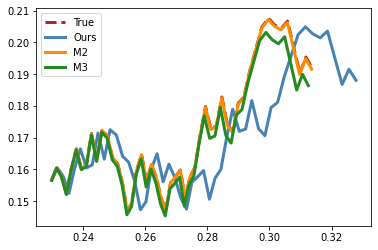

In [30]:
plt.plot(data_true[:,0], data_true[:,1], label='True', color='brown', linestyle='dashed', linewidth=3)
plt.plot(data_pred_list_pk[:,0], data_pred_list_pk[:,1], label='Ours', color='steelblue', linewidth=3)
plt.plot(data_pred_list_linear[:,0], data_pred_list_linear[:,1], label='M2', color='darkorange', linewidth=3)
plt.plot(data_pred_list_bilinear[:,0], data_pred_list_bilinear[:,1], label='M3', color='forestgreen', linewidth=3)

plt.legend()


In [10]:

# Linear Model: Dynamics is $Az +Bu$

dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

model_linear = solver_linear.build_model()

solver_linear.build(model_linear,
                    data_x,
                    data_u,
                    data_y,
                    zeros_data_y_train,
                    epochs=100,
                    batch_size=200,
                    lr=0.0001,
                    log_interval=20,
                    lr_decay_factor=0.1)


Epoch 1/10
125/125 [==============================] - 1s 3ms/step - loss: 0.5693 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 0s 3ms/step - loss: 0.4283 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 0s 3ms/step - loss: 0.3465 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2941 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2590 - lr: 1.0000e-04
Epoch 6/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2345 - lr: 1.0000e-04
Epoch 7/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2166 - lr: 1.0000e-04
Epoch 8/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2026 - lr: 1.0000e-04
Epoch 9/10
125/125 [==============================] - 0s 3ms/step - loss: 0.1907 - lr: 1.0000e-04
Epoch 10/10
125/125 [==============================] - 0s 2ms/step - loss: 0.1802 - lr: 1.0000e-04
number of the outer

2024-02-28 11:16:39.735749: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55ea6907e310


125/125 [==============================] - 0s 3ms/step - loss: 1.8743e-06 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 0s 3ms/step - loss: 1.9461e-07 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 0s 3ms/step - loss: 1.5833e-07 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 0s 3ms/step - loss: 1.3946e-07 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 1.2766e-07 - lr: 1.0000e-04
Epoch 6/10
125/125 [==============================] - 0s 3ms/step - loss: 1.1999e-07 - lr: 1.0000e-04
Epoch 7/10
125/125 [==============================] - 0s 3ms/step - loss: 1.1399e-07 - lr: 1.0000e-04
Epoch 8/10
125/125 [==============================] - 0s 3ms/step - loss: 1.0919e-07 - lr: 1.0000e-04
Epoch 9/10
125/125 [==============================] - 0s 3ms/step - loss: 1.0599e-07 - lr: 1.0000e-04
Epoch 10/10
125/125 [==============================] - 0s 3ms/step - loss: 1.0266e-07 - lr: 1

In [11]:

model_linear.save_weights(os.path.join(
        weights_path, 'test_model_linear_vdpm_mu_'+str(mu)+'.h5'))



In [12]:

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

model_bilinear = solver_bilinear.build_model()

solver_bilinear.build(model_bilinear,
                        data_x,
                        data_u,
                        data_y,
                        zeros_data_y_train,
                        epochs=100,
                        batch_size=200,
                        lr=0.0001,
                        log_interval=20,
                        lr_decay_factor=0.1)


Epoch 1/10
125/125 [==============================] - 1s 2ms/step - loss: 0.9007 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6347 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.4866 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3978 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3412 - lr: 1.0000e-04
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3033 - lr: 1.0000e-04
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2769 - lr: 1.0000e-04
Epoch 8/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2580 - lr: 1.0000e-04
Epoch 9/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2444 - lr: 1.0000e-04
Epoch 10/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2346 - lr: 1.0000e-04
number of the outer

125/125 [==============================] - 0s 2ms/step - loss: 5.3162e-07 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 1.8474e-07 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 1.1376e-07 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 1.0090e-07 - lr: 1.0000e-04
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 9.8625e-08 - lr: 1.0000e-04
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 9.7997e-08 - lr: 1.0000e-04
Epoch 8/10
125/125 [==============================] - 0s 2ms/step - loss: 9.8034e-08 - lr: 1.0000e-04
Epoch 9/10
125/125 [==============================] - 0s 2ms/step - loss: 9.8141e-08 - lr: 1.0000e-04
Epoch 10/10
125/125 [==============================] - 0s 2ms/step - loss: 9.7809e-08 - lr: 1.0000e-04
number of the outer loop: 1
Epoch 1/10
125/125 [==============================] - 0s 2ms/ste

In [13]:

model_bilinear.save_weights(os.path.join(
    weights_path, 'test_model_bilinear_vdpm_mu_'+str(mu)+'.h5'))


In [ ]:

# for mu, K_layer_size in zip(mu_list, K_layer_size_list):
#     load_data_and_train_models(mu, K_layer_size)
#     print('mu = ', mu, 'done')
#     print('K_layer_size = ', K_layer_size, 'done')

# load_data_and_train_models(mu=mu_list[0], K_layer_size=K_layer_size_list[0])
# print('mu = ', mu_list[0], 'done')
# print('K_layer_size = ', K_layer_size_list[0], 'done')

In [ ]:

# def load_data_and_train_models(mu, K_layer_size):

#     # Load data
#     dict_data = np.load(os.path.join(
#         data_path, 'vdpm_data_mu_'+str(mu)+'.npy'), allow_pickle=True)

#     data_x = dict_data[()]['data_x']
#     data_y = dict_data[()]['data_y']
#     data_u = dict_data[()]['data_u']

#     # PK-NN
#     dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)
#     from koopmanlib.K_structure import Model_K_u_Layer, Model_K_u_Layer_One

#     model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, 
#                                     n_psi=n_psi,
#                                     activation='tanh')

#     solver_pk = KoopmanParametricDLSolver(
#         target_dim=target_dim, 
#         param_dim=param_dim, 
#         n_psi=n_psi, 
#         dic=dic_pk, 
#         model_K_u=model_K_u)

#     model_pk, model_K_u_pred_pk = solver_pk.generate_model()

#     model_pk.summary()

#     zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

#     model_pk.compile(optimizer=Adam(0.001),
#                     loss='mse')
    
#     # model_pk.compile(optimizer=Adam(0.001),
#     #                 loss=my_loss)

#     lr_callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
#                                                         factor=0.1,
#                                                         patience=200,
#                                                         verbose=0,
#                                                         mode='auto',
#                                                         min_delta=0.0001,
#                                                         cooldown=0,
#                                                         min_lr=1e-6)

#     history = model_pk.fit(x=[data_x, data_y, data_u],
#                         y=zeros_data_y_train,
#                         epochs=pknn_epochs,
#                         batch_size=200,
#                         callbacks=lr_callbacks,
#                         verbose=1)


#     model_pk.save_weights(os.path.join(
#         weights_path, 'model_pk_vdpm_mu_'+str(mu)+'.h5'))

#     # # Linear Model: Dynamics is $Az +Bu$

#     # dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

#     # solver_linear = KoopmanLinearDLSolver(
#     #     dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

#     # model_linear = solver_linear.build_model()

#     # solver_linear.build(model_linear,
#     #                     data_x,
#     #                     data_u,
#     #                     data_y,
#     #                     zeros_data_y_train,
#     #                     epochs=linear_epochs,
#     #                     batch_size=200,
#     #                     lr=0.0001,
#     #                     log_interval=20,
#     #                     lr_decay_factor=0.1)

#     # model_linear.save_weights(os.path.join(
#     #     weights_path, 'model_linear_vdpm_mu_'+str(mu)+'.h5'))


#     # # Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

#     # dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

#     # solver_bilinear = KoopmanBilinearDLSolver(
#     #     dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

#     # model_bilinear = solver_bilinear.build_model()

#     # solver_bilinear.build(model_bilinear,
#     #                       data_x,
#     #                       data_u,
#     #                       data_y,
#     #                       zeros_data_y_train,
#     #                       epochs=linear_epochs,
#     #                       batch_size=200,
#     #                       lr=0.0001,
#     #                       log_interval=20,
#     #                       lr_decay_factor=0.1)

#     # model_bilinear.save_weights(os.path.join(
#     #     weights_path, 'model_bilinear_vdpm_mu_'+str(mu)+'.h5'))

# # for mu, K_layer_size in zip(mu_list, K_layer_size_list):
# #     load_data_and_train_models(mu, K_layer_size)
# #     print('mu = ', mu, 'done')
# #     print('K_layer_size = ', K_layer_size, 'done')

# load_data_and_train_models(mu=mu_list[0], K_layer_size=K_layer_size_list[0])
# print('mu = ', mu_list[0], 'done')
# print('K_layer_size = ', K_layer_size_list[0], 'done')